<a href="https://colab.research.google.com/github/denis-kezun/Sales-Analytics-store/blob/main/portfolio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Посилання на Tableau [https://public.tableau.com/app/profile/denis.kuzin/viz/SalesAnalysis_17571038852200/SalesAnalysis?publish=yes]

#Завантаження БД та перший аналіз

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import auth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, shapiro, mannwhitneyu, stats, f_oneway
import statsmodels.api as sm
from google.colab import drive
drive.mount("/content/drive")

# Changing work folder
%cd /content/drive/MyDrive/Mate

auth.authenticate_user()
client = bigquery.Client(project="data-analytics-mate")

Mounted at /content/drive
/content/drive/MyDrive/Mate


In [ ]:
query = """
    select
  s.date as order_date,
  s.ga_session_id as session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name as mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.name,
  sp.channel,
  a.id as account_id,
  a.is_verified,
  a.is_unsubscribed,
  p.category,
  p.name as item_name,
  p.price,
  p.short_description
from `DA.session_params` sp
left join `DA.account_session` acs
on sp.ga_session_id = acs.ga_session_id
left join `DA.account` a
on acs.account_id = a.id
left join `DA.order` o
on sp.ga_session_id = o.ga_session_id
left join `DA.product` p
on o.item_id = p.item_id
join `DA.session` s
on sp.ga_session_id = s.ga_session_id
"""
query_job = client.query(query)
results = query_job.result()
df = results.to_dataframe()
df

,order_date,session_id,continent,country,device,browser,mobile_model_name,operating_system,language,name,channel,account_id,is_verified,is_unsubscribed,category,item_name,price,short_description
0,2021-01-19,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-06,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-05,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-12-09,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-10,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349540,2020-11-25,353517,Americas,Canada,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None
349541,2020-11-09,2536581233,Americas,United States,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None
349542,2021-01-02,2149190429,Americas,Canada,desktop,Chrome,Safari,Macintosh,de,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None
349543,2021-01-08,6004211753,Americas,United States,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   session_id         349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   name               349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  item_name          33538 non-null   object 
 16  pr

In [ ]:
count_of_unique_sessions = df["session_id"].nunique()
count_of_unique_accounts = df["account_id"].nunique()
print(f"Кількість унікальних сессій: {count_of_unique_sessions}")
print(f"Кількість унікальних акаунтів: {count_of_unique_accounts}")

count_of_verified_accounts = df[df["is_verified"] == 1]["account_id"].nunique()
count_of_unverified_accounts = df[df["is_verified"] == 0]["account_id"].nunique()
print(f"\nКількість веріфікованих акаунтів: {count_of_verified_accounts}")
print(f"Кількість неверіфікованих акаунтів: {count_of_unverified_accounts}")

count_of_subscribed_accounts = df[df["is_unsubscribed"] == 0]["account_id"].nunique()
count_of_unsubscribed_accounts = df[df["is_unsubscribed"] == 1]["account_id"].nunique()
print(f"\nКількість акаунтів з підпискою: {count_of_subscribed_accounts}")
print(f"Кількість акаунтів без підписки: {count_of_unsubscribed_accounts}")

first_date_order = df["order_date"].min()
last_date_order = df["order_date"].max()
print(f"\nЗаявки розглядались в період з {first_date_order} до {last_date_order}\n")

df["price"].describe()

Кількість унікальних сессій: 349545
Кількість унікальних акаунтів: 27945

Кількість веріфікованих акаунтів: 20036
Кількість неверіфікованих акаунтів: 7909

Кількість акаунтів з підпискою: 23210
Кількість акаунтів без підписки: 4735

Заявки розглядались в період з 2020-11-01 до 2021-01-31



,price
count,33538.000000
mean,953.298679
std,1317.001775
min,3.000000
25%,170.000000
50%,445.000000
75%,1195.000000
max,9585.000000


In [ ]:
missing_value_percent = (df.isnull().mean()*100).round(2)
print(missing_value_percent)

order_date            0.00
session_id            0.00
continent             0.00
country               0.00
device                0.00
browser               0.00
mobile_model_name     0.00
operating_system      0.00
language             32.69
name                  0.00
channel               0.00
account_id           92.01
is_verified          92.01
is_unsubscribed      92.01
category             90.41
item_name            90.41
price                90.41
short_description    90.41
dtype: float64


#Короткий опис датасету
##1. Загальна кількість колонок складає - 18
---
##2. Кількість колонок числового типу - 5
- session_id  (int64)
- account_id  (int64)
- is_verified  (int64)
- is_unsubscribed  (int64)
- price  (float64)
---
##3. Кількість колонок категоріального типу - 12
- continent
- object
- country
- device
- browser
- mobile_model_name
- operating_system-language
- name
- channel
- category
- item_name
- short_description
---
##4. Кількість колонок типу datetime - 1
- order_date
---
##5. Інформація по акаунтам та сессіям
- Кількість унікальних сессій - 349545
- Кількість унікальних акаунтів - 27945
- Кількість веріфікованих акаунтів - 20036
- Кількість неверіфікованих акаунтів - 7909
- Кількість акаунтів з підпискою - 23210
- Кількість акаунтів без підпискою - 4735
---
##6. Інформація за цінами
- середня ціна товару - 953.3$

- мінімальна ціна товару - 3$

- максимальна кількість товару - 9585$
---
##7. Інформація розглядається з 01.11.2020 до 31.01.2021
---
##8. Інформація по пропущеним даним
###1. Пропуски наявні у таких полях як:
- language (32.69%)
- account_id (92.01)
- is_verified (92.01)
- is_unsubscribed (92.01)
- category (90.41%)
- item_name (90.41%)
- price (90.41%)
- short_description (90.41%)
###2. Пропуски у полях
- Пропуски у полі language виникають, якщо браузер, через який була сессія не передав інформацію про мову.
- Пропуский у полях account_id, is_verified, is_unsubscribed виникають через те, що не всі користувачі створюють акаунти, які використовуються для сессії.
- Пропуски у полях category, item_name, price, short_description виникають через те, що не у всіх сессіях є замовлення. Можливо користувач просто зайшов подивитися продукт без покупки.

на яких континентах (топ-3) та в яких країнах (топ-5) наша компанія має найбільші продажі? найбільшу кількість замовлень?


#Відповіді на питання

In [ ]:
continent_group_by_price = df.groupby("continent")["price"].sum().sort_values(ascending=False).head(3)
print(continent_group_by_price)
print()
country_group_by_price = df.groupby("country")["price"].sum().sort_values(ascending=False).head(5)
print(country_group_by_price)
print()
continent_group_by_orders = df.groupby("continent")["session_id"].count().sort_values(ascending=False).head(3)
print(continent_group_by_orders)
print()
country_group_by_orders = df.groupby("country")["session_id"].count().sort_values(ascending=False).head(5)
print(country_group_by_orders)

continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: price, dtype: float64

country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: price, dtype: float64

continent
Americas    193179
Asia         83113
Europe       65135
Name: session_id, dtype: Int64

country
United States     153470
India              32763
Canada             25994
United Kingdom     11003
France              6958
Name: session_id, dtype: Int64


знайди топ-10 категорій товарів за загальною сумою продажів

In [ ]:
category_group_by_price = df.groupby("category")["price"].sum().sort_values(ascending=False).head(10)
print(category_group_by_price)

category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0
Name: price, dtype: float64


знайди топ-10 категорій товарів у країні з найбільшими продажами, чи відрізняється ситуація від загальної?


In [ ]:
country_max_selling = df.groupby("country")["price"].sum().sort_values(ascending=False).head(1)
top_country = country_max_selling.index[0]
top_10_category_by_top_country = df[df["country"]==top_country].groupby("category")["price"].sum().sort_values(ascending=False).head(10)
print(top_10_category_by_top_country)

category
Sofas & armchairs                   3707144.5
Chairs                              2619773.8
Beds                                2213058.0
Bookcases & shelving units          1567606.9
Cabinets & cupboards                 994545.5
Outdoor furniture                    929245.2
Tables & desks                       777865.0
Chests of drawers & drawer units     382388.0
Bar furniture                        330805.0
Children's furniture                 207575.0
Name: price, dtype: float64


проаналізуй продажі у розрізі типів та моделей девайсів (у % від загальних продажів)

In [ ]:
total_price = df["price"].sum()
device_groupby = (df.groupby("device")["price"].sum().sort_values(ascending=False) / total_price *100).round(2)
model_device_groupby = (df.groupby("mobile_model_name")["price"].sum().sort_values(ascending=False) / total_price *100).round(2)

print(device_groupby)
print()
print(model_device_groupby)

device
desktop    59.00
mobile     38.73
tablet      2.26
Name: price, dtype: float64

mobile_model_name
Chrome        27.84
<Other>       20.44
Safari        20.30
iPhone        20.08
ChromeBook     5.73
Edge           2.18
iPad           1.40
Firefox        1.32
Pixel 4 XL     0.37
Pixel 3        0.34
Name: price, dtype: float64


проаналізуй продажі за джерелами трафіку (у % від загальних продажів)

In [ ]:
channel_groupby = (df.groupby("channel")["price"].sum().sort_values(ascending=False) / total_price *100).round(2)
print(channel_groupby)

channel
Organic Search    35.76
Paid Search       26.62
Direct            23.44
Social Search      7.92
Undefined          6.26
Name: price, dtype: float64


який відсоток зареєстрованих користувачів підтвердив свою електронну адресу?

In [ ]:
regestration_account = df[df["account_id"].notnull()]
regestration_account_total = regestration_account["account_id"].nunique()
print(regestration_account_total)
is_verified_users = round(regestration_account[regestration_account["is_verified"] == 1]["account_id"].nunique() / regestration_account_total * 100,2)
print(is_verified_users)

27945
71.7


який відсоток зареєстрованих користувачів відписався від розсилки?

In [ ]:
is_unsubscribed_users = round(regestration_account[regestration_account["is_unsubscribed"] == 1]["account_id"].nunique() / regestration_account_total * 100,2)
print(is_unsubscribed_users)

16.94


чи відрізняється поведінка (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний?


In [ ]:
new_dataset = (regestration_account.groupby("is_unsubscribed")["price"].agg(["sum", "mean", "count"]).rename(columns={"sum": "total_selling", "mean": "average_bill", "count": "orders_count"},index={0: "subscribed", 1: "unsubscribed"}))

diff = new_dataset.loc["subscribed"] - new_dataset.loc["unsubscribed"]
percent = diff / new_dataset.loc["subscribed"] * 100
new_dataset.loc["difference"] = diff
new_dataset.loc["difference_%"] = percent
print(new_dataset)

                 total_selling  average_bill  orders_count
is_unsubscribed                                           
subscribed        2.150797e+06    921.506812   2334.000000
unsubscribed      4.317216e+05    965.820134    447.000000
difference        1.719075e+06    -44.313322   1887.000000
difference_%      7.992737e+01     -4.808789     80.848329


в яких країнах найбільше зареєстрованих користувачів?

In [ ]:
regestration_account_groupby = regestration_account.groupby("country")["account_id"].nunique().sort_values(ascending=False).head(10)
print(regestration_account_groupby)

country
United States     12384
India              2687
Canada             2067
United Kingdom      859
France              553
Spain               536
Taiwan              500
China               490
Germany             490
Italy               386
Name: account_id, dtype: int64


In [ ]:
language_notnull = df[df["language"].notnull()]
language_notnull_group_by = (language_notnull.groupby("language")["session_id"].count() / language_notnull["language"].count() * 100).round(1)
print(language_notnull_group_by)

language
de        1.4
en        4.9
en-ca     4.0
en-gb    10.5
en-us    68.0
es-es     2.4
fr        2.4
ko        1.2
zh        5.2
Name: session_id, dtype: Float64


In [ ]:
item_group_by_price = df.groupby("short_description")["price"].sum().sort_values(ascending=False).head(10)
print(item_group_by_price)

short_description
3-seat sofa-bed                   1118634.0
3-seat sofa                       1026360.0
4-seat sofa                        897004.0
Corner sofa, 5-seat                750280.0
Corner sofa, 4-seat                693825.0
Table and 6 chairs, 180/240 cm     603640.0
Table and 6 chairs, 220x100 cm     540510.0
Corner sofa-bed, 5-seat            518955.0
2-seat sofa                        467118.0
Table and 4 chairs, 140x85 cm      437560.0
Name: price, dtype: float64


In [ ]:
group_by_order_date = df.groupby("order_date")["price"].sum().sort_values(ascending=False).head(5)
print(group_by_order_date)

order_date
2020-12-08    680509.5
2020-12-10    624104.6
2021-01-06    609763.8
2020-12-16    553134.9
2020-12-09    551811.6
Name: price, dtype: float64


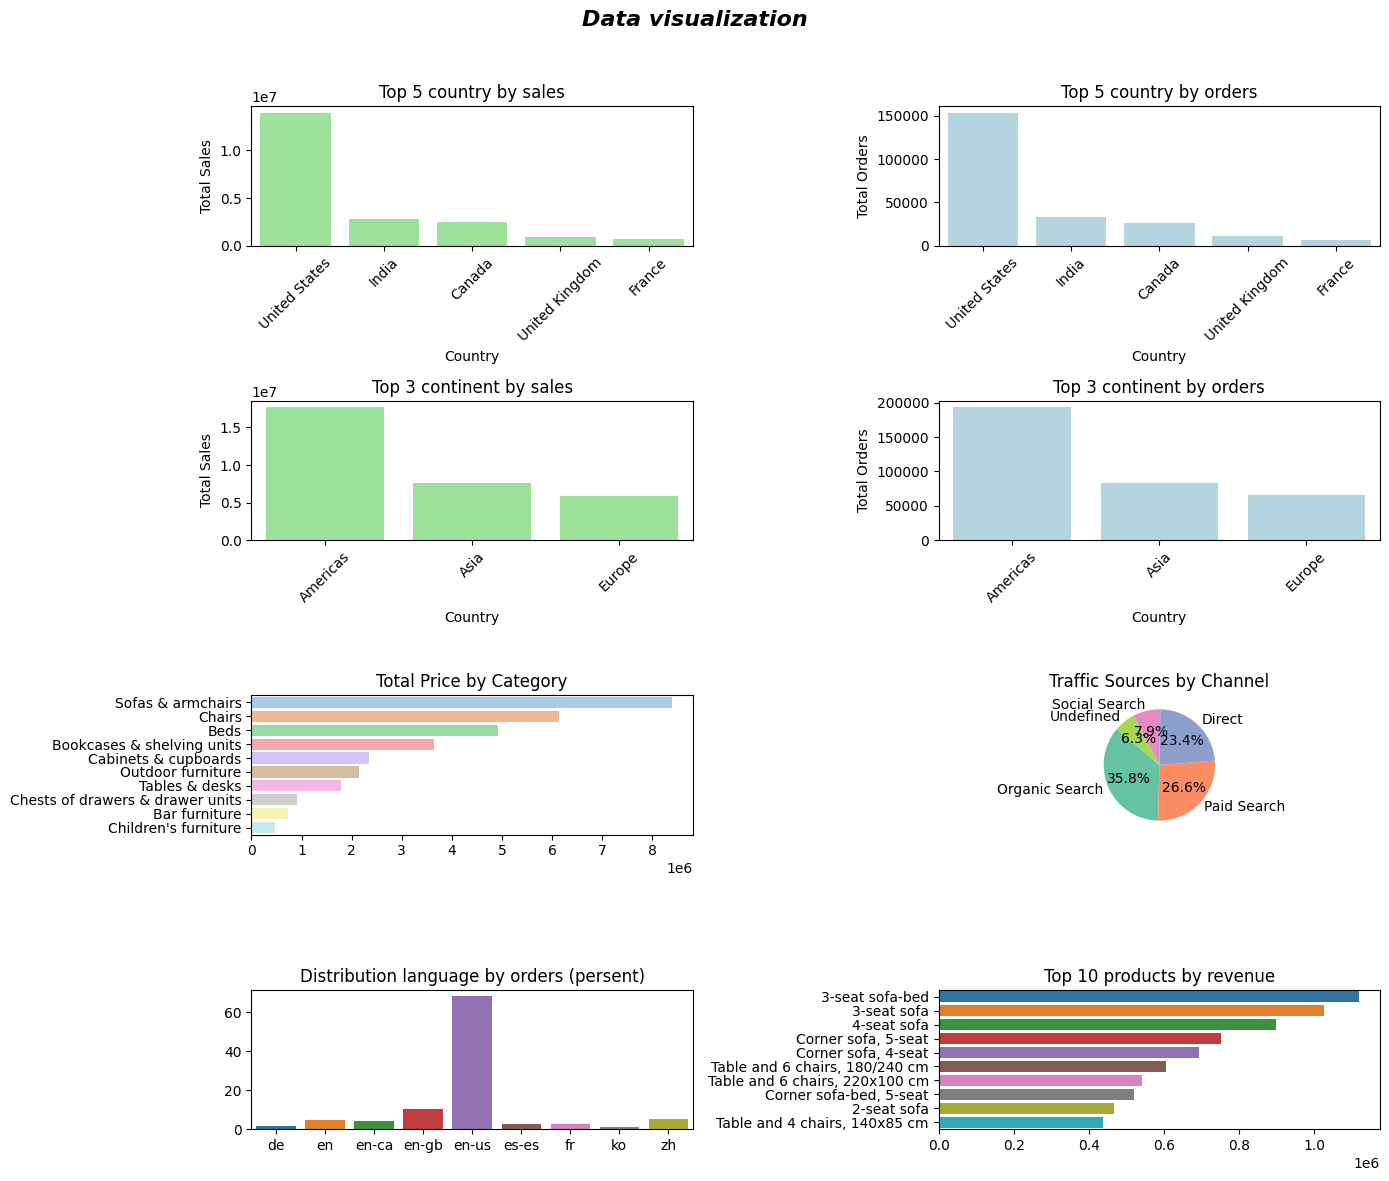

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(14, 12))
fig.suptitle("Data visualization",fontweight="bold", fontstyle="italic", fontsize=16)

sns.barplot(x=country_group_by_price.index, y=country_group_by_price.values,
            ax=ax[0,0], color="lightgreen")
ax[0,0].set_title("Top 5 country by sales")
ax[0,0].set_xlabel("Country")
ax[0,0].tick_params(axis='x', rotation=45)
ax[0,0].set_ylabel("Total Sales")


sns.barplot(x=country_group_by_orders.index, y=country_group_by_orders.values,
            ax=ax[0,1], color="lightblue")
ax[0,1].set_title("Top 5 country by orders")
ax[0,1].set_xlabel("Country")
ax[0,1].tick_params(axis='x', rotation=45)
ax[0,1].set_ylabel("Total Orders")


sns.barplot(x=continent_group_by_price.index, y=continent_group_by_price.values,
            ax=ax[1,0], color="lightgreen")
ax[1,0].set_title("Top 3 continent by sales")
ax[1,0].set_xlabel("Country")
ax[1,0].tick_params(axis='x', rotation=45)
ax[1,0].set_ylabel("Total Sales")


sns.barplot(x=continent_group_by_orders.index, y=continent_group_by_orders.values,
            ax=ax[1,1], color="lightblue")
ax[1,1].set_title("Top 3 continent by orders")
ax[1,1].set_xlabel("Country")
ax[1,1].tick_params(axis='x', rotation=45)
ax[1,1].set_ylabel("Total Orders")


sns.barplot(x=category_group_by_price.values, y=category_group_by_price.index,
            hue=category_group_by_price.index, ax=ax[2,0], palette="pastel", legend=False )
ax[2,0].set_title("Total Price by Category")
ax[2,0].set_xlabel("")
ax[2,0].set_ylabel("")


ax[2,1].pie(channel_groupby.values,
            labels=channel_groupby.index,
            autopct="%.1f%%",
            startangle=140,colors=plt.cm.Set2.colors)
ax[2,1].set_title("Traffic Sources by Channel")

sns.barplot(x=language_notnull_group_by.index,
            y=language_notnull_group_by.values,
            hue=language_notnull_group_by.index, ax=ax[3,0],
            legend=False)
ax[3,0].set_title("Distribution language by orders (persent)")
ax[3,0].set_xlabel("")
ax[3,0].set_ylabel("")

sns.barplot(x=item_group_by_price.values,
            y=item_group_by_price.index,
            hue=item_group_by_price.index, ax=ax[3,1],
            legend=False)
ax[3,1].set_title("Top 10 products by revenue")
ax[3,1].set_xlabel("")
ax[3,1].set_ylabel("")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

#Аналіз продажів
---
##Топ 3 континенів за рівнем продажів

1. **Americas** (17665280$)

2. **Asia** (7601298$)

3. **Europe** (5934624$)

---

##Топ 5 країн за рівнем продажів

1. **United States** (13943554$)

2. **India** (2809762$)

3. **Canada** (2437921$)

4. **United Kingdom** (938317$)

5. **France** (710693$)

---

##Топ 3 континентів за кількість замовлень

1. **Americas** (193179)

2. **Asia** (83113)

3. **Europe** (65135)

---
##Топ 5 країн за кількістю замовлень

1. **United States** (153470)

2. **India** (32763)

3. **Canada** (25994)

4. **United Kingdom** (11003)

5. **France** (6958)

---

##Топ 10 категорій товарів за загальною сумою продажів

1. **Sofas & armchairs** (8388255$)

2. **Chairs** (6147749$)

3. **Beds** (4919725$)

4. **Bookcases & shelving units** (3640818$)

5. **Cabinets & cupboards** (2336500$)

6. **Outdoor furniture** (2142222$)

7. **Tables & desks** (1790308$)

8. **Chests of drawers & drawer units** (906563$)

9. **Bar furniture** (735503$)

10. **Children's furniture** (467697$)

---

##Топ 10 категорій товарів за загальною сумою продажів у країні з найбільшими продажами

1. **Sofas & armchairs** (3707145$)

2. **Chairs** (2619774$)

3. **Beds** (2213058$)

4. **Bookcases & shelving units** (1567607$)

5. **Cabinets & cupboards** (994546$)

6. **Outdoor furniture** (929245$)

7. **Tables & desks** (777865$)

8. **Chests of drawers & drawer units** (382388$)

9. **Bar furniture** (330805$)

10. **Children's furniture** (207575$)
 ---
Як у загальному списку, так і в списку для країни з найбільшими продажами (**United States**), топ-10 категорій товарів залишаються ідентичними, і вони розташовані в тому ж порядку. Відрізняються лише абсолютні значення продажів для кожної категорії, оскільки другий список відображає лише частину від загальної суми.

---

##Продажі у розрізі типів девайсів (% від загального)

1. **Desktop** (59.00%)

2. **Mobile** (38.73%)

3. **Tablet** (2.26%)

---

##Продажі у розрізі моделей девайсів (% від загального)

1. **Chrome** (27.84%)

2. **Other** (20.44%)

3. **Safari** (20.30%)

4. **iPhone** (20.08%)

5. **ChromeBook** (5.73%)

6. **Edge** (2.18%)

7. **iPad** (1.40%)

8. **Firefox** (1.32%)

9. **Pixel 4 XL** (0.37%)

10. **Pixel 3** (0.34%)

---

##Продажі за джерелами трафіку (% від загального)

1. **Organic Search** (35.76 %)

2. **Paid Search** (26.62 %)

3. **Direct** (23.44 %)

4. **Social Search** (7.92 %)

5. **Undefined** (6.26 %)

---

##Аналіз відсотка зареєстрованих користувачів, які підтвердили свою електронну адресу

**Відсоток акаунтів, які підтвердили свою пошту**: 71.7%

---

#Аналіз відсотка зареєстрованих користувачів, які відписалися від розсилки

**Відсоток зареєстрованих користувачів, без підписки**: 16.94%

---

##Аналіз поведінки (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний

1. Загальні сума продажів
- у тих, хто підписаний складає - 2150797 $

- у не підписаних на розсилку - 431722 $

  **Різниця більше ніж у 5 разів**.

2. Середня вартість одного чеку
- для підписнаних на розсилку складає 922
-у не підписаних - 966

  **У відписаних клієнтів вартість чеку трохи вище.**

3. Загальна кількість замовлень
- у підписаних - 2334
- у не підписаних - 447

  **Різниця більше ніж у 5 разів.**
---

##Топ країн за зареєстрованими користувачами

1. **United States** (12384)

2. **India** (2687)

3. **Canada** (2067)

4. **United Kingdom** (859)

5. **France** (553)

6. **Spain** (536)

7. **Taiwan** (500)

8. **China** (490)

9. **Germany** (490)

10. **Italy** (386)
---
##Аназіл мов (% від загального)

1. **de** (1.4%)

2. **en** (4.9%)

3. **en-ca** (4.0%)

4. **en-gb** (10.5%)

5. **en-us** (68.0%)

6. **es-es** (2.4%)

7. **fr** (2.4%)

8. **ko** (1.2%)

9. **zh** (5.2%)
---
##Топ 10 продуктів за загальною сумою продажів
1. **3-seat sofa-bed**  (1118634$)

2. **3-seat sofa** (1026360$)

3. **4-seat sofa** (897004$)

4. **Corner sofa, 5-seat** (750280$)

5. **Corner sofa, 4-seat** (693825$)

6. **Table and 6 chairs, 180/240 cm** (603640$)

7. **Table and 6 chairs, 220x100 cm** (540510$)

8. **Corner sofa-bed, 5-seat** (518955$)

9. **2-seat sofa** (467118$)

10. **Table and 4 chairs, 140x85 cm** (437560$)

---

##Топ 5 дат з найбільшими продажами
1. **2020-12-08** (680510)
2. **2020-12-10** (624105)
3. **2021-01-06** (609764)
4. **2020-12-16** (553134)
5. **2020-12-09** (551812)

#Аналіз динаміки продажів

##Загальні продажі за датами

Text(0.5, 0, 'Order Date')

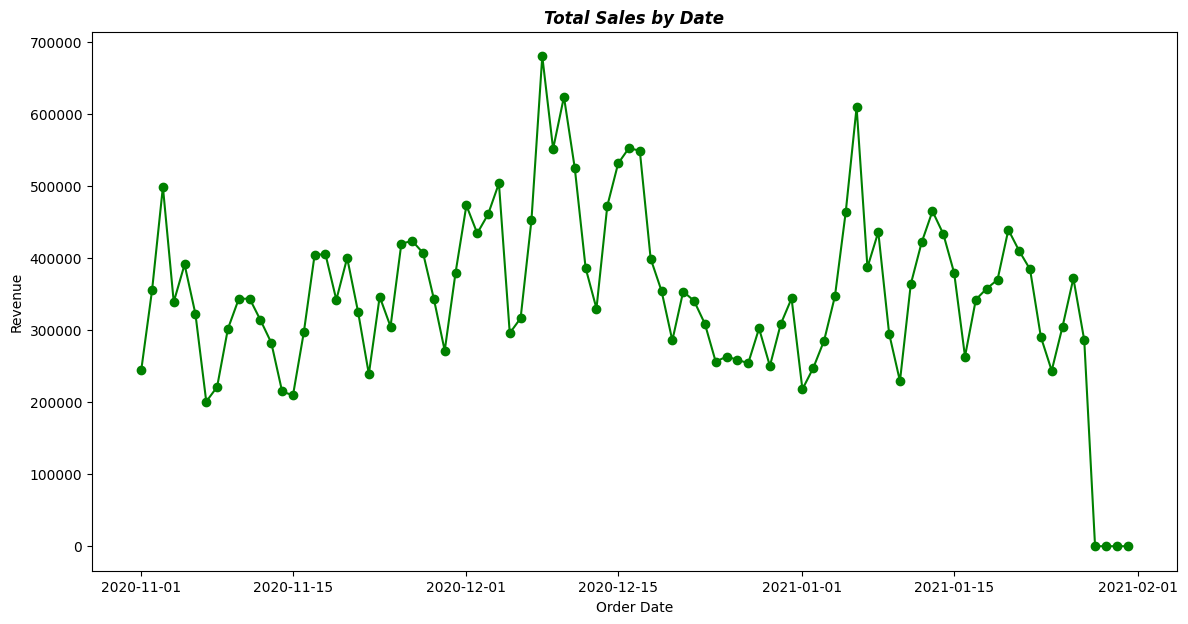

In [ ]:
total_sales_by_date = df.groupby("order_date")["price"].sum()
plt.figure(figsize=(14,7))
total_sales_by_date.plot(x = "order_date", y = "price", kind = "line", marker = "o", color = "green")
plt.title("Total Sales by Date", fontweight="bold", fontstyle="italic")
plt.ylabel("Revenue")
plt.xlabel("Order Date")

Згідно з графіком, спостерігається різкі коливання, продажі не рівномірні протягом року. Найбільші продажі спостерігаються в середині грудня 2020 року та на початку січня 2021 року. Це, ймовірно, пов'язано з святами. Наприкінці січня 2021 року спостерігається різкий спад майже до 0.

##Динаміка продажів за континентами

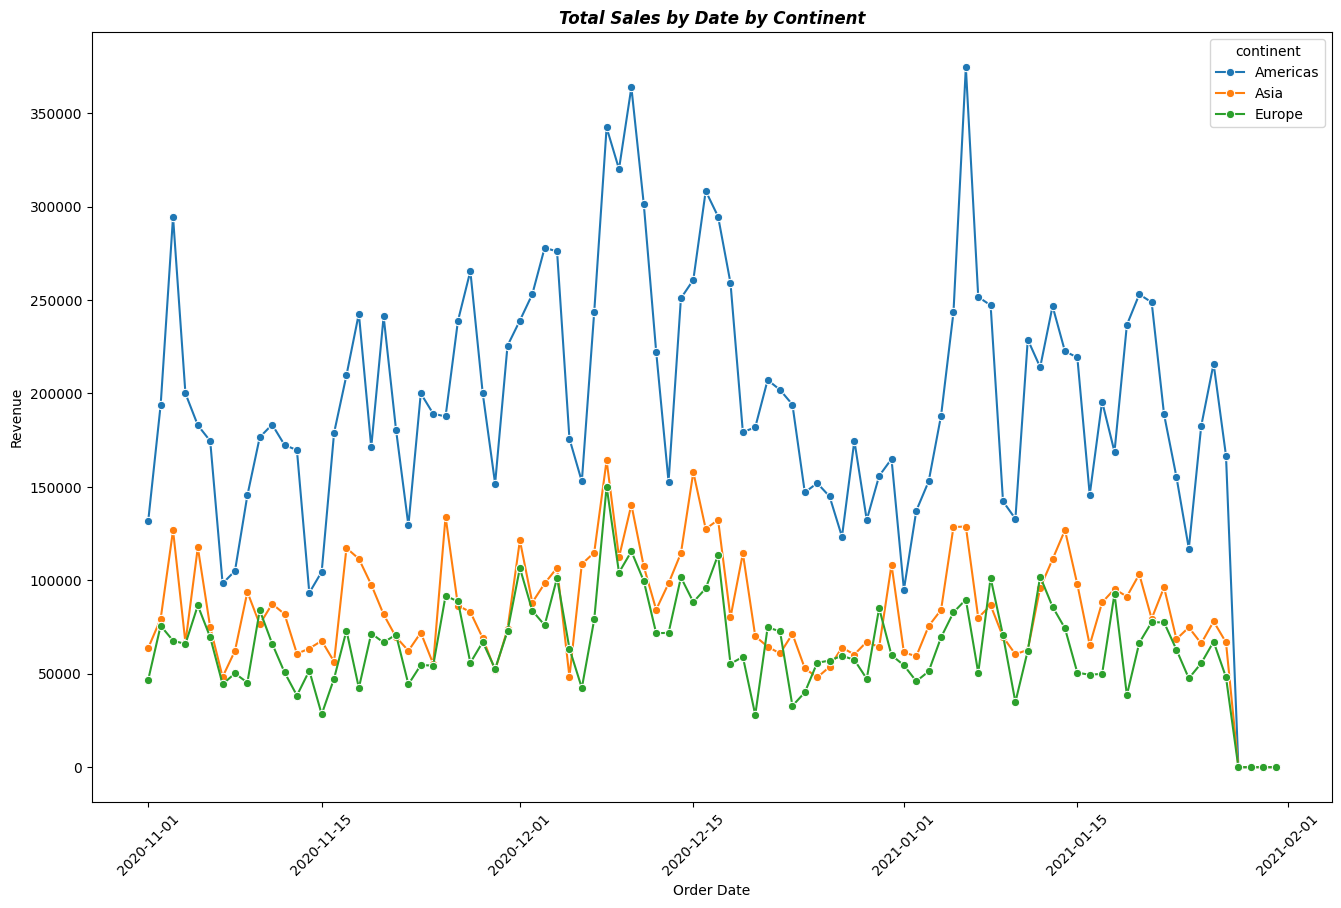

In [ ]:
sales_by_continent = df[df["continent"].isin(["Americas", "Asia", "Europe"])]
sales_by_continent_group_by = sales_by_continent.groupby(["order_date","continent"])["price"].sum().reset_index()
plt.figure(figsize=(16,10))
sns.lineplot(
    data=sales_by_continent_group_by,
    x="order_date",
    y="price",
    hue="continent",
    marker="o"
)
plt.title("Total Sales by Date by Continent", fontweight="bold", fontstyle="italic")
plt.ylabel("Revenue")
plt.xlabel("Order Date")
plt.xticks(rotation=45)
plt.show()

##Динаміка продажів за каналами продажів

Згідно з діаграмою, Америка є лідером за продажами протягом усього часу порівнянно з іншими (Европою та Аізєю). Дані щодо Европи та Азії демонструють схожі тенденції, проте, доходи Азії все одно трохи вищі ніж в Европі. Піки продажів у всіх трьох континентах схожі, у середині грудня 2020 року та на початку січня 2021 року. Як і на попередній діаграмі, маємо різке падіння за всіма континентами наприкінці січня 2021 року.

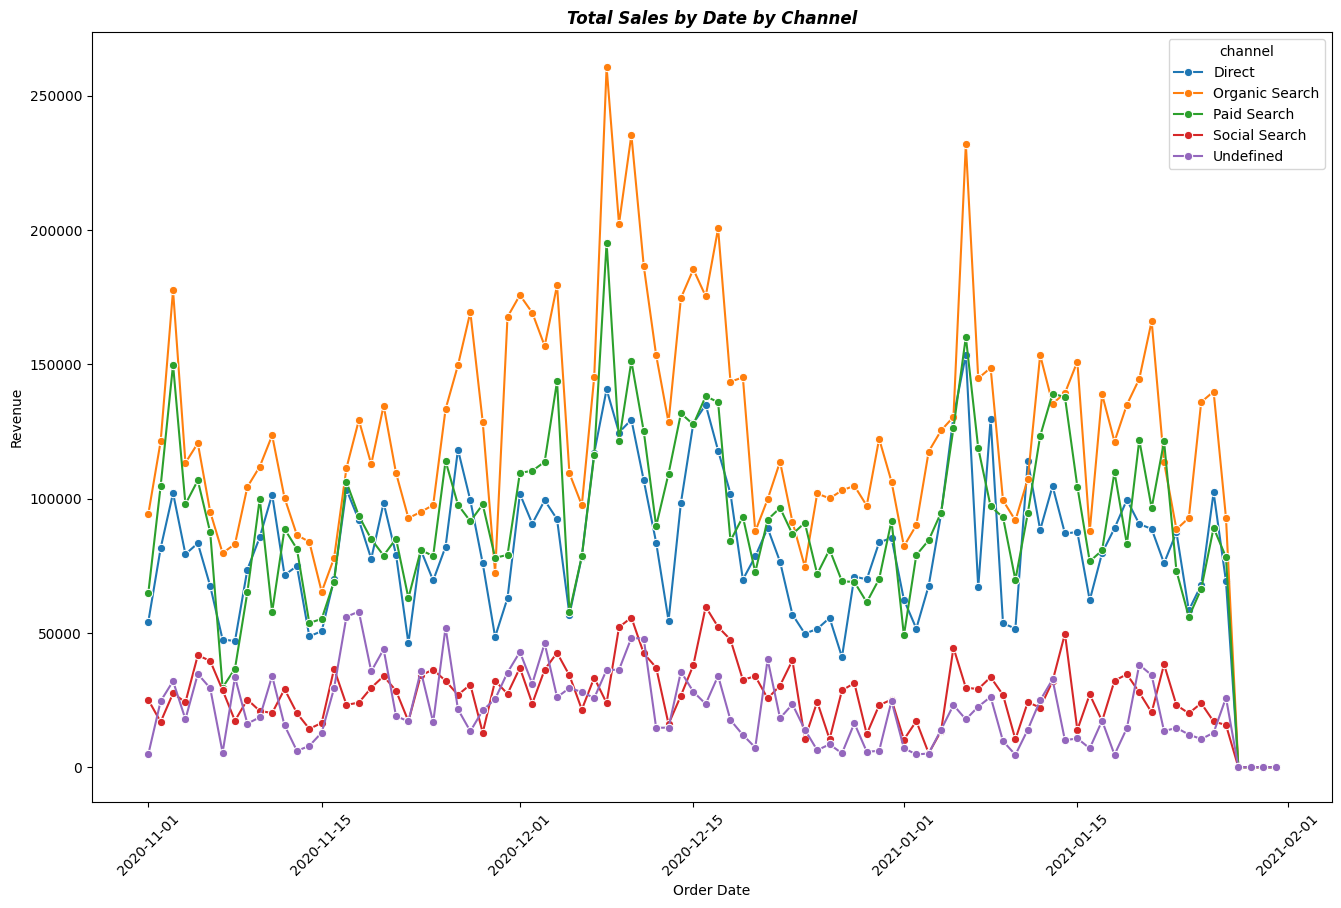

In [ ]:
sales_by_channel_group_by = sales_by_continent.groupby(["order_date","channel"])["price"].sum().reset_index()
plt.figure(figsize=(16,10))
sns.lineplot(
    data=sales_by_channel_group_by,
    x="order_date",
    y="price",
    hue="channel",
    marker="o"
)
plt.title("Total Sales by Date by Channel", fontweight="bold", fontstyle="italic")
plt.ylabel("Revenue")
plt.xlabel("Order Date")
plt.xticks(rotation=45)
plt.show()

##Динаміка продажів за пристроями

Згідно з діаграмою, Organic Search є каналом, який приносить найбільший дохід. Канали Direct та Paid Search їдуть одразу після Organic Search та мають схожі показники, хоча Paid Search приносить трохи більше доходу порівняно з Direct. Канали Social Search та Undefined мають найменший дохід, який не перевищує 50000, мають схожі тенденції (інколи Social Search трохи більше, іноді Undefined).

Порівняно з минулими діаграмами зберігається тенденція зростання доходу в середині грудня 2020 року та на початку січня 2021, і падіння наприкінці січня 2021.

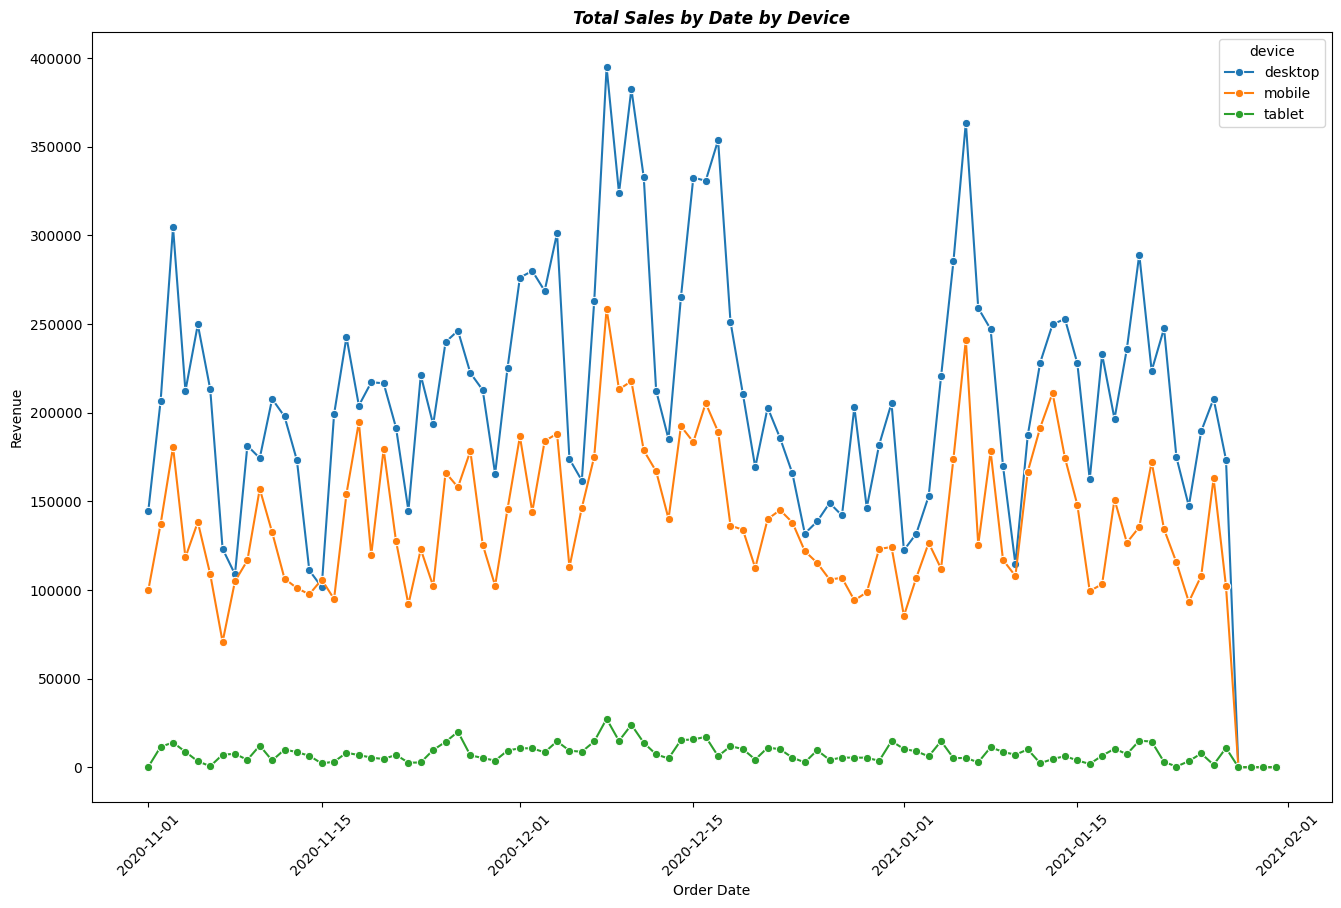

In [ ]:
sales_by_device = df.groupby(["order_date","device"])["price"].sum().sort_values(ascending = False).reset_index()
plt.figure(figsize=(16,10))
sns.lineplot(
    data=sales_by_device,
    x="order_date",
    y="price",
    hue="device",
    marker="o"
)
plt.title("Total Sales by Date by Device", fontweight="bold", fontstyle="italic")
plt.ylabel("Revenue")
plt.xlabel("Order Date")
plt.xticks(rotation=45)
plt.show()

Згідно з діаграмою, комп’ютерна версія (desktop) має найвищі показники доходу порівняно з іншими платформами. Динаміка мобільної версії подібна до комп’ютерної, проте рівень доходів дещо нижчий. Сезонні коливання для цих версій збігаються з попередніми діаграмами. Планшетна версія (tablet) є найменш прибутковою: її динаміка стабільна, а дохід не перевищує 30 000.

#Зведені таблиці


##Кількість сесій у розрізі каналів трафіку та типів девайсів

In [ ]:
pivot_table_sessions_channel = pd.pivot_table(df, values = "session_id", index = "channel", columns = "device", aggfunc ="count")
pivot_table_sessions_channel

device,desktop,mobile,tablet
channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


##Загальні продажі за категоріями товарів (Топ 10 категорій у Топ 5 країнах)

In [ ]:
category_top = df.groupby("category")["price"].sum().nlargest(10).index
country_top = df.groupby("country")["price"].sum().nlargest(5).index
pivot_table_df = df[df["category"].isin(category_top) & df["country"].isin(country_top)]
pivot_table_revenue_category = pd.pivot_table(pivot_table_df, values="price", index="category", columns="country", aggfunc="sum",)
pivot_table_revenue_category

country,Canada,France,India,United Kingdom,United States
category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


##Кількість сессій для кожної категорії у розрізі каналів

In [ ]:
pivot_table_order_by_category_device = pd.pivot_table(df, values = "session_id", index = "category", columns = "device", aggfunc = "count")
pivot_table_order_by_category_device

device,desktop,mobile,tablet
category,,,
Bar furniture,646,420,26
Beds,1677,1190,59
Bookcases & shelving units,4437,3035,158
Cabinets & cupboards,1379,888,51
Café furniture,213,142,4
Chairs,3528,2287,137
Chests of drawers & drawer units,857,568,27
Children's furniture,1026,644,32
Nursery furniture,227,159,8


##Середній чек для кожного каналу у розрізі статуса підписки

In [ ]:
pivot_table_avg_bill_by_subscription = pd.pivot_table(df, values = "price", index = "channel", columns = "is_unsubscribed", aggfunc = "mean")
pivot_table_avg_bill_by_subscription = pivot_table_avg_bill_by_subscription.rename(columns={0: "Subscribed", 1: "Unsubscribed"})
pivot_table_avg_bill_by_subscription

is_unsubscribed,Subscribed,Unsubscribed
channel,,
Direct,948.389159,1005.435644
Organic Search,891.516353,1063.497590
Paid Search,925.333222,808.644860
Social Search,866.683684,843.125000
Undefined,1041.720625,1065.480000


#Статистичний аналіз взаємозв’язків

##Взаємозв’язок між кількістю сесій та загальними продажами за кожну дату

In [ ]:
count_session = df.groupby("order_date")["session_id"].nunique()
total_sales = df.groupby("order_date")["price"].sum()
print(f"Test statistic and p-value: {pearsonr(count_session, total_sales)}")

Test statistic and p-value: PearsonRResult(statistic=np.float64(0.7910809164540891), pvalue=np.float64(6.483532312080735e-21))


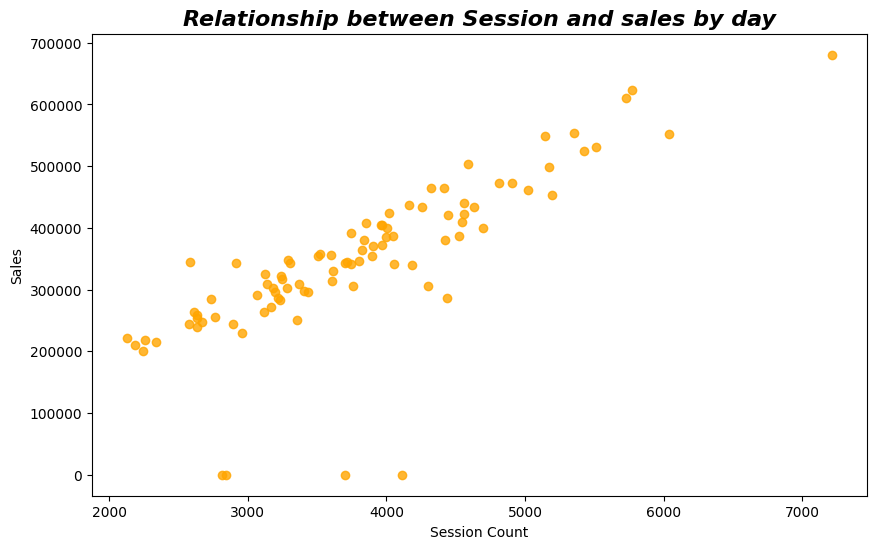

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(count_session, total_sales, alpha = 0.8, color = "orange")
plt.title("Relationship between Session and sales by day", fontweight="bold", fontstyle="italic", fontsize=16)
plt.xlabel("Session Count")
plt.ylabel("Sales")
plt.show()

За допомогою статичного метода Пірсона ми обчислили коефіцієнт кореляції між нашими змінними (кількістю сессій та загальними продажами за днями), і отримали наступні результати, що зв'язок є дуже сильний і значення p-value < 0.05 -> можна з високою впевненістю стверджувати, що зв'язок між змінними дійсно існує. Отже, можна казати, що зріст кількості сессій може впливати на зріст продажів.

##Взаємозв’язок продажів на різних континентах (Топ 3 континентів)

In [ ]:
top_continent = df.groupby("continent")["price"].sum().nlargest(3)
data_continent = df[df["continent"].isin(top_continent.index)]
continent_table = pd.pivot_table(data_continent, values = "price",index="order_date", columns = "continent", aggfunc= "sum")
corr_continent_table = continent_table.corr(method="pearson")
corr_continent_table

continent,Americas,Asia,Europe
continent,,,
Americas,1.000000,0.792025,0.770586
Asia,0.792025,1.000000,0.768427
Europe,0.770586,0.768427,1.000000


In [ ]:
americas_asia_corr, americas_asia_p  = pearsonr(continent_table["Americas"], continent_table["Asia"])
print(f"Correlation between sales in Americas and Asia: {americas_asia_corr}, p-value: {americas_asia_p}")
americas_europe_corr, americas_europe_p  = pearsonr(continent_table["Americas"], continent_table["Europe"])
print(f"Correlation between sales in Americas and Europe: {americas_europe_corr}, p-value: {americas_europe_p}")
europe_asia_corr, europe_asia_p  = pearsonr(continent_table["Europe"], continent_table["Asia"])
print(f"Correlation between sales in Americas and Asia: {europe_asia_corr}, p-value: {europe_asia_p}")

Correlation between sales in Americas and Asia: 0.7920245629479414, p-value: 5.409189396197475e-21
Correlation between sales in Americas and Europe: 0.7705864582886499, p-value: 2.6714492240629956e-19
Correlation between sales in Americas and Asia: 0.7684273823164164, p-value: 3.8649460090531196e-19


##Взаємозв’язок продажів за різними каналами трафіку

In [ ]:
channel_table = pd.pivot_table(df, values = "price", index = "order_date", columns = "channel", aggfunc="sum")
corr_channel_table = channel_table.corr(method = "pearson")
corr_channel_table

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
channel,,,,,
Direct,1.000000,0.837833,0.814072,0.604060,0.517505
Organic Search,0.837833,1.000000,0.870086,0.583117,0.526068
Paid Search,0.814072,0.870086,1.000000,0.596428,0.521961
Social Search,0.604060,0.583117,0.596428,1.000000,0.455126
Undefined,0.517505,0.526068,0.521961,0.455126,1.000000


##Взаємозв’язок продажів за топ-5 категоріями товарів

In [ ]:
top_category = df.groupby("category")["price"].sum().nlargest(5)
data_category = df[df["category"].isin(top_category.index)]
category_pivot_table = pd.pivot_table(data_category, values = "price",index="order_date", columns = "category", aggfunc= "sum")
corr_category_pivot_table = category_pivot_table.corr(method = "pearson")
corr_category_pivot_table

category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
category,,,,,
Beds,1.000000,0.592913,0.514609,0.554500,0.535378
Bookcases & shelving units,0.592913,1.000000,0.539428,0.637090,0.666194
Cabinets & cupboards,0.514609,0.539428,1.000000,0.572870,0.657563
Chairs,0.554500,0.637090,0.572870,1.000000,0.578248
Sofas & armchairs,0.535378,0.666194,0.657563,0.578248,1.000000


In [ ]:
for category_1 in category_pivot_table.columns:
  for category_2 in category_pivot_table.columns:
    if category_1 != category_2:
      corr, p_value = pearsonr(category_pivot_table[category_1], category_pivot_table[category_2])
      print(f"Corelation between {category_1} and {category_2}: {corr}; p-value is: {p_value}")

Corelation between Beds and Bookcases & shelving units: 0.5929126076179512; p-value is: 1.1549982399950595e-09
Corelation between Beds and Cabinets & cupboards: 0.5146092811149645; p-value is: 2.9109296191322004e-07
Corelation between Beds and Chairs: 0.5544997375988838; p-value is: 2.079182865492252e-08
Corelation between Beds and Sofas & armchairs: 0.5353782861422639; p-value is: 7.687332925177328e-08
Corelation between Bookcases & shelving units and Beds: 0.5929126076179512; p-value is: 1.1549982399950595e-09
Corelation between Bookcases & shelving units and Cabinets & cupboards: 0.5394281705433275; p-value is: 5.8672250979394714e-08
Corelation between Bookcases & shelving units and Chairs: 0.6370904868409913; p-value is: 2.5045503773672356e-11
Corelation between Bookcases & shelving units and Sofas & armchairs: 0.6661941326624645; p-value is: 1.4069719486806666e-12
Corelation between Cabinets & cupboards and Beds: 0.5146092811149645; p-value is: 2.9109296191322004e-07
Corelation be

##Взаємозв'язок між середнім чеком та кількістю замовлень за день.

In [ ]:
order_by_date = df.groupby("order_date")["session_id"].nunique()
sales_by_date = df.groupby("order_date")["price"].sum()
avg_bill_data = pd.DataFrame({"orders": order_by_date, "sales": sales_by_date, "avg_bill": sales_by_date / order_by_date})
corr, p_value = pearsonr(order_by_date, sales_by_date)
print(f"Correlation coefficient (r): {corr}")
print(f"P-value: {p_value}")

Correlation coefficient (r): 0.7910809164540891
P-value: 6.483532312080735e-21


#Статистичний аналіз відмінностей між групами

##Аналіз продажів за кожну дату зареєстрованих та незареєстрованих користувачів

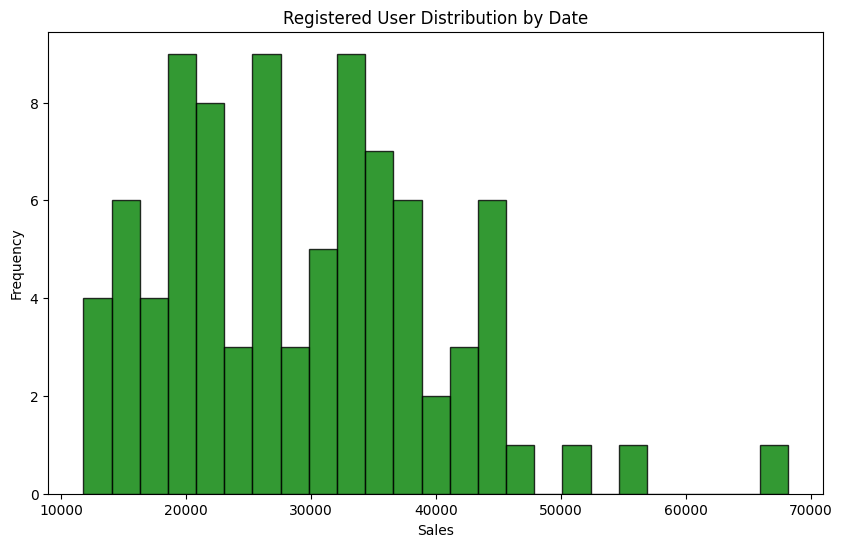

In [ ]:
registered_info = df[df["account_id"] != 0]
registered_info_sales = registered_info.groupby(["order_date"])["price"].sum()
registered_info_sales
plt.figure(figsize=(10,6))
plt.hist(registered_info_sales, bins = 25, alpha = 0.8, color = "green", edgecolor = "black")
plt.title("Registered User Distribution by Date")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

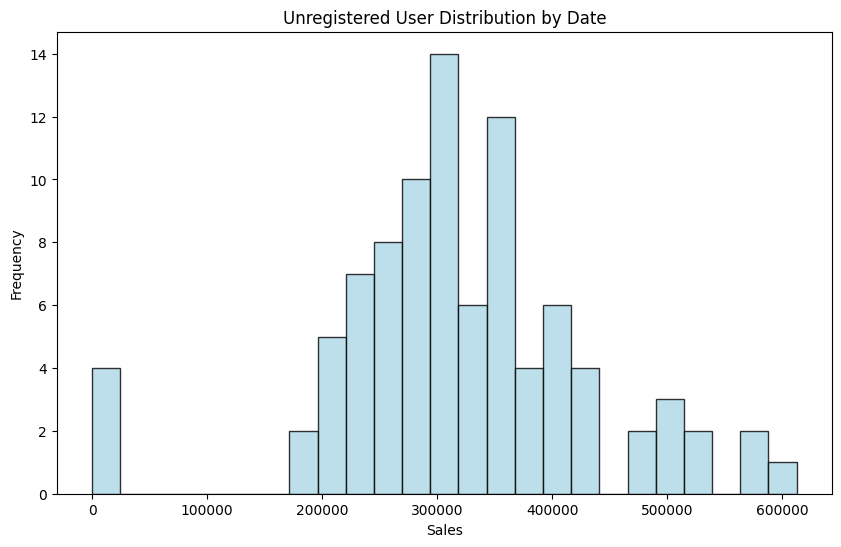

In [ ]:
unregistered_info = df[df["account_id"].isna()]
unregistered_info_sales = unregistered_info.groupby(["order_date"])["price"].sum()
unregistered_info_sales
plt.figure(figsize=(10,6))
plt.hist(unregistered_info_sales, bins = 25, alpha = 0.8, color = "lightblue", edgecolor = "black")
plt.title("Unregistered User Distribution by Date")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

Оскільки як у вибірці зареєстрованих, так і у вибірці незареєстрованих користувачів дані продажів не відповідають нормальному розподілу (що підтверджується тестом Шапіро–Уїлка, p-value < 0.05).
Крім того, розмір вибірок відносно невеликий, що ще більше підвищує ризик порушення припущень параметричних тестів.
У таких умовах доцільним є використання непараметричного тесту Манна–Вітні, який не вимагає нормальності та дозволяє коректно порівнювати медіани та розподіли двох незалежних вибірок.

In [ ]:
print("Shapiro registered:", shapiro(registered_info_sales))
print("Shapiro unregistered:", shapiro(unregistered_info_sales))

Shapiro registered: ShapiroResult(statistic=np.float64(0.9591810175035426), pvalue=np.float64(0.007295139880540744))
Shapiro unregistered: ShapiroResult(statistic=np.float64(0.9487769113384333), pvalue=np.float64(0.0012184604855253293))


In [ ]:
u_stat, p_value = mannwhitneyu(registered_info_sales, unregistered_info_sales, alternative="two-sided")
print(f"Mann–Whitney U: U={u_stat}, p={p_value:.3e}")

Mann–Whitney U: U=352.0, p=3.881e-26


Існує статистично значуща різниця між розподілами продажів зареєстрованих та незареєстрованих користувачів. Це означає, що факт реєстрації користувача суттєво впливає на рівень продажів.

##Aналіз кількості сесій за різними каналами трафіку

In [ ]:
pivot_table_sessions_by_channel = pd.pivot_table(df, values="session_id", index="order_date", columns="channel", aggfunc="count")
pivot_table_sessions_by_channel
f_stat, p_value = f_oneway(pivot_table_sessions_by_channel["Direct"],
                           pivot_table_sessions_by_channel["Organic Search"],
                           pivot_table_sessions_by_channel["Paid Search"],
                           pivot_table_sessions_by_channel["Social Search"],
                           pivot_table_sessions_by_channel["Undefined"])
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")
print()
print("Mean value for Direct:", np.mean(pivot_table_sessions_by_channel["Direct"]))
print("Mean value for Organic Search:", np.mean(pivot_table_sessions_by_channel["Organic Search"]))
print("Mean value for Paid Search:", np.mean(pivot_table_sessions_by_channel["Paid Search"]))
print("Mean value for Social Search:", np.mean(pivot_table_sessions_by_channel["Social Search"]))
print("Mean value for Undefined:", np.mean(pivot_table_sessions_by_channel["Undefined"]))

F-statistic: 439.7675316990713
P-value: 8.433830529447116e-155

Mean value for Direct: 884.5869565217391
Mean value for Organic Search: 1352.445652173913
Mean value for Paid Search: 1025.445652173913
Mean value for Social Search: 303.4130434782609
Mean value for Undefined: 233.5108695652174


Є статистично значуща різниця у середній кількості сесій між каналами.

Найбільший внесок у трафік дає Organic Search, найменший — Undefined та Social Search.

##Статистична доля сесій з органічним трафіком у Європі та Америці

In [ ]:
europe_america_data = df[(df["continent"]=="Americas") | (df["continent"]=="Europe")]
europe_organic = europe_america_data[(europe_america_data["continent"] == "Europe") & (europe_america_data["channel"] == "Organic Search")].groupby("order_date")["session_id"].count()
america_organic = europe_america_data[(europe_america_data["continent"] == "Americas") & (europe_america_data["channel"] == "Organic Search")].groupby("order_date")["session_id"].count()
europe_cnt = europe_america_data[europe_america_data["continent"]=="Europe"]["session_id"].count()
america_cnt = europe_america_data[europe_america_data["continent"]=="Americas"]["session_id"].count()
europe_organic
z_stat, p_value = sm.stats.proportions_ztest([europe_organic.sum(), america_organic.sum()], [europe_cnt,america_cnt])
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

Z-statistic: 0.28951412926103953
P-value: 0.7721879690501752


Pізниця між долями органічних сесій у Європі та Америці не є статистично значущою.